<p style='font-size:1.75rem;line-height:1.5'>
    Classify if Pi's were less than or equal to 6 ft apart using Logistic Regression <br> Features: Humidity, Temperature, Received Signal Strength Indication (RSSI)
    </p>

In [12]:
import pandas as pd
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
%matplotlib inline
from math import *
from sklearn.model_selection import train_test_split

In [13]:
data = pd.read_csv("../Zeng_Eloise_CollectedData/pi_pact_data.csv")
data.insert(0, 'ones', 1)
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = np.reshape(y_train.to_numpy(), (len(y_train),1))
y_test = np.reshape(y_test.to_numpy(), (len(y_test),1))
data

,ones,humidity,temperature,RSSI,tctl
0,1,65.0,88.2,-52.250000,1
1,1,82.5,79.2,-51.033898,1
2,1,65.5,80.7,-60.380952,1
3,1,37.0,102.0,-56.666667,1
4,1,37.0,102.0,-56.666667,1
...,...,...,...,...,...
140,1,62.0,72.3,-58.103448,0
141,1,66.0,66.2,-62.017241,0
142,1,24.0,114.6,-54.278689,0
143,1,38.0,86.4,-54.034483,0


In [14]:
maxes = pd.Series(data.iloc[:, 1:3].max(), name='Max')
mins = pd.Series(data.iloc[:, 1:3].min(), name='Min')
pd.concat([maxes, mins], axis=1)

,Max,Min
humidity,94.0,20.0
temperature,117.2,66.2


In [15]:
import scipy.optimize as op 

def sigmoid(z):
    z = np.ones(z.shape) / (1 + np.exp(-z))
    return z

def Gradient(theta,x,y):
    m,n = x.shape
    theta = theta.reshape((n,1)) 
    y = y.reshape((m,1))
    sigmoid_x_theta = sigmoid(x.dot(theta)) 
    grad = ((x.T).dot(sigmoid_x_theta-y))/m 
    return grad.flatten() 

def CostFunc(theta,x,y):
    m,n = x.shape  
    theta = theta.reshape((n,1)) 
    y = y.reshape((m,1)) 
    term1 = np.log(sigmoid(x.dot(theta))) 
    term2 = np.log(1-sigmoid(x.dot(theta))) 
    term1 = term1.reshape((m,1))
    term2 = term2.reshape((m,1))
    term = y * term1 + (1 - y) * term2 
    J = -((np.sum(term))/m) 
    return J 

m, n = X_train.shape
initial_theta = np.zeros((n, 1))
Result = op.minimize(fun = CostFunc, # Use function from scipy.optimize to do logistic regression on training data.
                     x0 = initial_theta, 
                     args = (X_train, y_train),
                     method = 'TNC',
                     jac = Gradient) 

theta = Result.x # optimal theta
Result

     fun: 0.6064565370339403
     jac: array([-3.50603507e-07, -5.30300784e-04, -5.86364534e-04,  6.59874435e-04])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 49
     nit: 16
  status: 1
 success: True
       x: array([ 1.31180446e+01,  9.53615167e-03, -1.08473606e-02,  2.12814159e-01])

In [16]:
# Predicts if Pis were TCTL using x's features and theta
def predict(x):
    predict = sigmoid(np.dot(x, theta))
    predict[predict >= 0.5] = 1 # Threshold == 0.5 gives highest training accuracy and F1 Score is 0.55
    predict[predict < 0.5] = 0 #  
#     predict[predict >= 0.8] = 1 # Threshold == 0.8 gives highest F1 Score, but test accuracy is 48.65%
#     predict[predict < 0.8] = 0
    return predict

In [17]:
# Concatenate predictions on X_test and y_test
pred_y_test = np.concatenate([np.reshape(predict(X_test), (len(y_test), 1)), y_test], axis=1)
# Calculate accuracy (# of correct predictions / # of cases)
acc_test = round((np.ravel(sum(pred_y_test[:, 0] == pred_y_test[:, 1])/len(y_test))[0]) * 100, 2)
# Concatenate predictions on X_train and y_train
pred_y_train = np.concatenate([np.reshape(predict(X_train), (len(y_train), 1)), y_train], axis=1)
# Calculate accuracy (# of correct predictions / # of cases)
acc_train = round((np.ravel(sum(pred_y_train[:, 0] == pred_y_train[:, 1])/len(y_train))[0] * 100), 2)
print("Train accuracy: ", acc_train, "%")
print("Test accuracy: ", acc_test, "%")
percent_pos_train = round((sum(sum(y_train)) / len(y_train)) * 100) # % of cases are positive in training data
percent_pos_test = round((sum(sum(y_test)) / len(y_test)) * 100) # % of cases are positive in testing data
print(percent_pos_train, "% of cases are positive in training data")
print(percent_pos_test, "% of cases are positive in testing data")

Train accuracy:  64.81 %
Test accuracy:  59.46 %
57 % of cases are positive in training data
57 % of cases are positive in testing data


In [18]:
pos_indice = np.nonzero(pred_y_train[:, 0]) # Get indices where computer predicted y_train == 1
neg_indice = np.nonzero(pred_y_train[:, 0] == 0) # Get indices where computer predicted y_train == 1

# Store number of predictions that...
true_neg = sum(sum(pred_y_train[pos_indice, 0] == pred_y_train[pos_indice, 1])) 
# == y_train when prediction == 0
false_neg = sum(sum(pred_y_train[pos_indice, 0] != pred_y_train[pos_indice, 1])) 
# != y_train when prediction == 0
true_pos = sum(sum(pred_y_train[neg_indice, 0] == pred_y_train[neg_indice, 1])) 
# == y_train when prediction == 1
false_pos = sum(sum(pred_y_train[neg_indice, 0] != pred_y_train[neg_indice, 1])) 
# != y_train when prediction == 1
precision = round(true_pos / (false_pos + true_pos), 3)
recall = round(true_pos / (false_neg + true_pos), 3)
false_pos_rate = round(false_pos / (false_pos + true_neg), 3)
true_neg_rate = round(true_neg / (true_neg + false_neg), 3) # not sure if true negative rate is correct name
f1 = round(2 * precision * recall / (precision + recall), 3) # F1 Score
data = {'Actual Positive': [true_pos, false_neg, 'true pos rate: ' + str(recall)], 
        'Actual Negative': [false_pos, true_neg, 'false pos rate: ' + str(false_pos_rate)], 
        'Actual Positive / (Actual Positive + Actual Negative)': ['precision: ' + str(precision), true_neg_rate, 'F1 Score: ' + str(f1)]}
print("Train Data")
confusion_matrix = pd.DataFrame(data, index=['Predict Positive', 'Predict Negative', 'Predict Positive / (Predict Positive + Predict Negative)'])
confusion_matrix

Train Data


,Actual Positive,Actual Negative,Actual Positive / (Actual Positive + Actual Negative)
Predict Positive,23,15,precision: 0.605
Predict Negative,23,47,0.671
Predict Positive / (Predict Positive + Predict Negative),true pos rate: 0.5,false pos rate: 0.242,F1 Score: 0.548


In [19]:
pos_indice = np.nonzero(pred_y_test[:, 0])
neg_indice = np.nonzero(pred_y_test[:, 0] == 0)

# Store number of predictions that...
true_neg = sum(sum(pred_y_test[pos_indice, 0] == pred_y_test[pos_indice, 1])) 
# == y_train when predictions == 0
false_neg = sum(sum(pred_y_test[pos_indice, 0] != pred_y_test[pos_indice, 1])) 
# != y_train when predictions == 0
true_pos = sum(sum(pred_y_test[neg_indice, 0] == pred_y_test[neg_indice, 1])) 
# == y_train when prediction == 1
false_pos = sum(sum(pred_y_test[neg_indice, 0] != pred_y_test[neg_indice, 1])) 
# != y_train when prediction == 1
precision = round(true_pos/(false_pos + true_pos), 3)
recall = round(true_pos/(false_neg + true_pos), 3)
false_pos_rate = round(false_pos / (false_pos + true_neg), 3)
true_neg_rate = round(true_neg / (true_neg + false_neg), 3)
f1 = round(2 * precision * recall / (precision + recall), 3) # F1 Score
data = {'Actual Positive': [true_pos, false_neg, 'true pos rate: ' + str(recall)], 
        'Actual Negative': [false_pos, true_neg, 'false pos rate: ' + str(false_pos_rate)], 
        'Actual Positive / (Actual Positive + Actual Negative)': ['precision: ' + str(precision), true_neg_rate, 'F1 Score: ' + str(f1)]}
print("Test Data")
confusion_matrix = pd.DataFrame(data, index=['Predict Positive', 'Predict Negative', 'Predict Positive / (Predict Positive + Predict Negative)'])
confusion_matrix

Test Data


,Actual Positive,Actual Negative,Actual Positive / (Actual Positive + Actual Negative)
Predict Positive,8,7,precision: 0.533
Predict Negative,8,14,0.636
Predict Positive / (Predict Positive + Predict Negative),true pos rate: 0.5,false pos rate: 0.333,F1 Score: 0.516


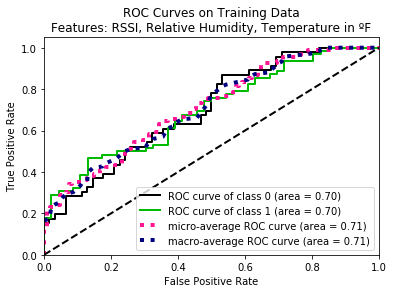

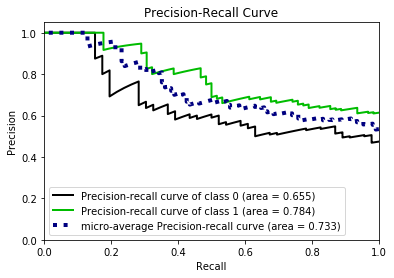

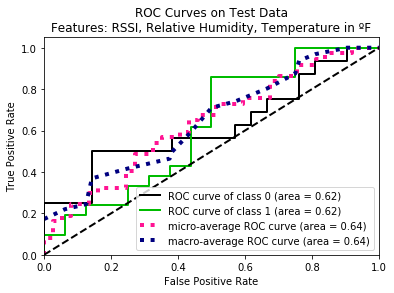

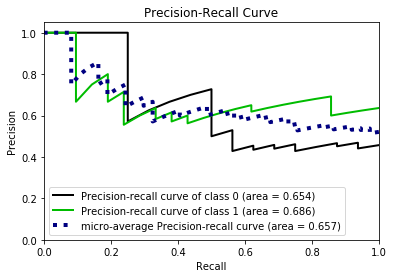

In [20]:
# Predicts if Pis were TCTL using x's features and theta
def prob(x):
    prob_1 = sigmoid(np.dot(x, theta))
    prob_0 = np.ones(len(x)) - prob_1
    return prob_1, prob_0

import scikitplot as skplt
y_probas_1 = np.reshape(prob(X_train)[0], (len(X_train), 1)) # Probability of training example == 1
y_probas_0 = np.reshape(prob(X_train)[1], (len(X_train), 1)) # Probability of training example == 0
y_probas = np.concatenate((y_probas_0, y_probas_1), axis=1)
skplt.metrics.plot_roc(np.ravel(y_train), y_probas, 
                       title='ROC Curves on Training Data\nFeatures: RSSI, Relative Humidity, Temperature in ºF') # Plot ROC Curve
skplt.metrics.plot_precision_recall(np.ravel(y_train), y_probas)
plt.show()

y_probas_1 = np.reshape(prob(X_test)[0], (len(X_test), 1)) # Probability of test example == 1
y_probas_0 = np.reshape(prob(X_test)[1], (len(X_test), 1)) # Probability of test example == 0
y_probas = np.concatenate((y_probas_0, y_probas_1), axis=1)
skplt.metrics.plot_roc(np.ravel(y_test), y_probas, title='ROC Curves on Test Data\nFeatures: RSSI, Relative Humidity, Temperature in ºF') # Plot ROC Curve
skplt.metrics.plot_precision_recall(np.ravel(y_test), y_probas)
plt.show()

## 3D Graphs (Comment out %matplotlib inline in the first cell to see an iteractive 3D plot) The z-axis is RSSI values. The z-label only shows up in the interative plot)

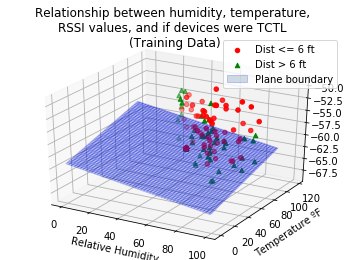

In [21]:
from mpl_toolkits.mplot3d import Axes3D

pos = np.nonzero(y_train == 1)
neg = np.nonzero(y_train == 0)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_train[pos, 1], X_train[pos, 2], X_train[pos, 3], color='r', label='Dist <= 6 ft')
ax.scatter(X_train[neg, 1], X_train[neg, 2], X_train[neg, 3], color='g', label='Dist > 6 ft', marker='^')

ax.set_xlabel('Relative Humidity')
ax.set_ylabel('Temperature ºF')
ax.set_zlabel('RSSI', labelpad=10)
ax.set_title('Relationship between humidity, temperature, \nRSSI values, and if devices were TCTL \n(Training Data)')
ax.legend()
# Equation for plane = theta[0] + theta[1] * x + theta[2] * y + theta[3] * z = 0
# x = humidity, y = temperature, z = RSSI_val

# create x,y
xx, yy = np.meshgrid(range(100), range(100))

# calculate corresponding z
z = (-theta[1] * xx - theta[2] * yy - theta[0]) * 1 / theta[3]

# plot the surface
plane = ax.plot_surface(xx, yy, z, alpha=0.2, label='Plane boundary', facecolor='b', edgecolor='b')
plane._facecolors2d=plane._facecolors3d
plane._edgecolors2d=plane._edgecolors3d
ax.legend()
plt.show()

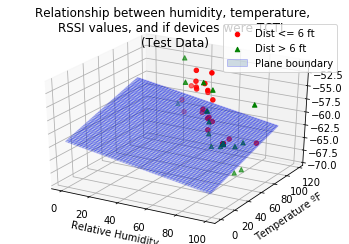

In [22]:
from mpl_toolkits.mplot3d import Axes3D

pos = np.nonzero(y_test == 1)
neg = np.nonzero(y_test == 0)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_test[pos, 1], X_test[pos, 2], X_test[pos, 3], color='r', label='Dist <= 6 ft')
ax.scatter(X_test[neg, 1], X_test[neg, 2], X_test[neg, 3], color='g', label='Dist > 6 ft', marker='^')

ax.set_xlabel('Relative Humidity')
ax.set_ylabel('Temperature ºF')
ax.set_zlabel('RSSI', labelpad=10)
ax.set_title('TC4TL')
ax.set_title('Relationship between humidity, temperature, \nRSSI values, and if devices were TCTL \n(Test Data)')
# Equation for plane: theta[0] + theta[1] * x + theta[2] * y + theta[3] * z = 0
# x = humidity, y = temperature, z = RSSI

# create x,y
xx, yy = np.meshgrid(range(100), range(100))

# calculate corresponding z
z = (-theta[1] * xx - theta[2] * yy - theta[0]) * 1 / theta[3]

# plot the surface
plane = ax.plot_surface(xx, yy, z, alpha=0.2, label='Plane boundary', facecolor='b', edgecolor='b')
plane._facecolors2d=plane._facecolors3d
plane._edgecolors2d=plane._edgecolors3d
ax.legend()
plt.show()